In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [13]:
# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [16]:
def test_strategy(ticker, start_date="2020-01-01", end_date="2025-02-10"):
    # Fetch historical data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate SMAs and RSI
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['SMA200'] = data['Close'].rolling(window=200).mean()
    data['RSI'] = calculate_rsi(data)

    # Generate Buy/Sell Signals
    data['Signal'] = 0
    data.loc[(data['SMA50'] > data['SMA200']), 'Signal'] = 1  # Buy signal
    data.loc[(data['SMA50'] < data['SMA200']), 'Signal'] = -1  # Sell signal

    # Filter signals based on RSI thresholds
    data.loc[data['RSI'] > 70, 'Signal'] = -1  # Overbought (Sell)
    data.loc[data['RSI'] < 30, 'Signal'] = 1  # Oversold (Buy)

    # Initialize portfolio variables
    initial_balance = 10000
    position = 0
    cash_balance = initial_balance

    slippage_rate = 0.001  # Slippage rate of 0.1%
    transaction_cost_rate = 0.001  # Transaction cost rate of 0.1%

    for index, row in data.iterrows():
        signal_value = row['Signal'].item()  # Extract signal (buy/sell)
        close_value = row['Close'].item()   # Extract close price

        # Adjust close value for slippage
        adjusted_close_value = close_value * (1 + slippage_rate if signal_value == 1 else 1 - slippage_rate)

        if signal_value == 1 and cash_balance > adjusted_close_value:  
            # Buy signal: Purchase as many shares as possible after accounting for transaction costs
            transaction_cost = adjusted_close_value * transaction_cost_rate
            max_shares_to_buy = cash_balance // (adjusted_close_value + transaction_cost)
            position += max_shares_to_buy
            cash_balance -= max_shares_to_buy * (adjusted_close_value + transaction_cost)

        elif signal_value == -1 and position > 0:
            # Sell signal: Sell all shares held, deducting transaction costs
            transaction_cost = adjusted_close_value * position * transaction_cost_rate
            cash_balance += position * adjusted_close_value - transaction_cost
            position = 0

    # Final portfolio value calculation
    final_stock_value = position * data.iloc[-1]['Close'].item()
    portfolio_value = cash_balance + final_stock_value

    print(f"Final Portfolio Value for {ticker}: ${portfolio_value:.2f}")

    # Plot the strategy performance
    plt.figure(figsize=(14,7))
    plt.plot(data.index, data['Close'], label='Close Price', alpha=0.5)
    plt.plot(data.index, data['SMA50'], label='SMA50', linestyle='--')
    plt.plot(data.index, data['SMA200'], label='SMA200', linestyle='--')

    buy_signals = data[data['Signal'] == 1]
    sell_signals = data[data['Signal'] == -1]

    plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green')
    plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red')

    plt.title(f"{ticker} Trading Strategy")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed


Final Portfolio Value for AAPL: $12003.28


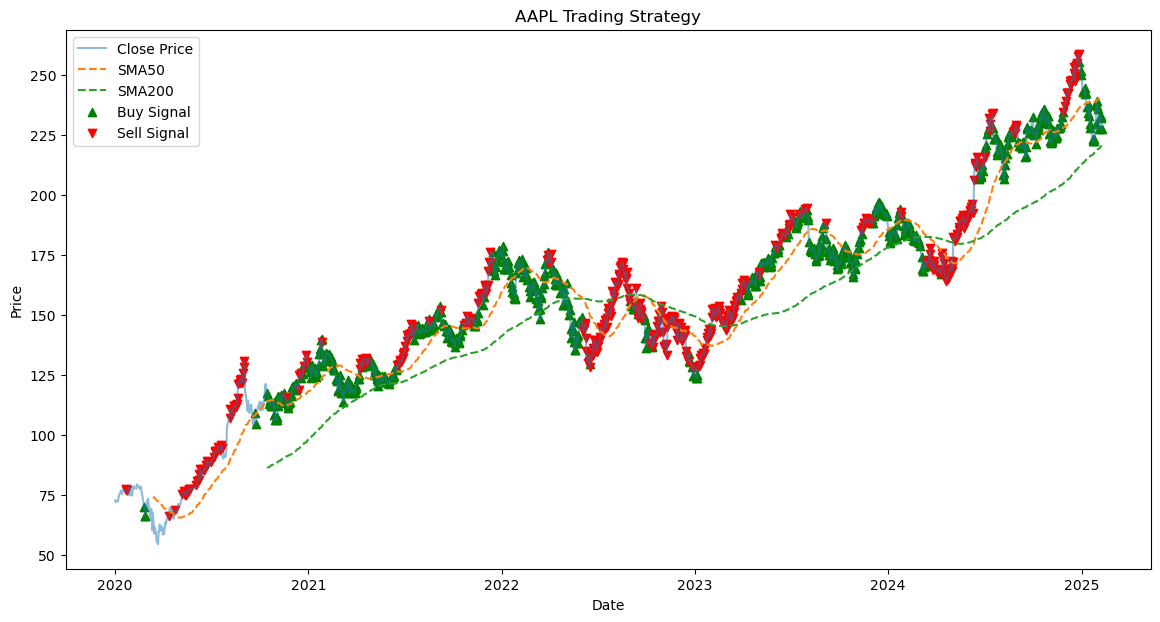

[*********************100%***********************]  1 of 1 completed


Final Portfolio Value for XOM: $9409.44


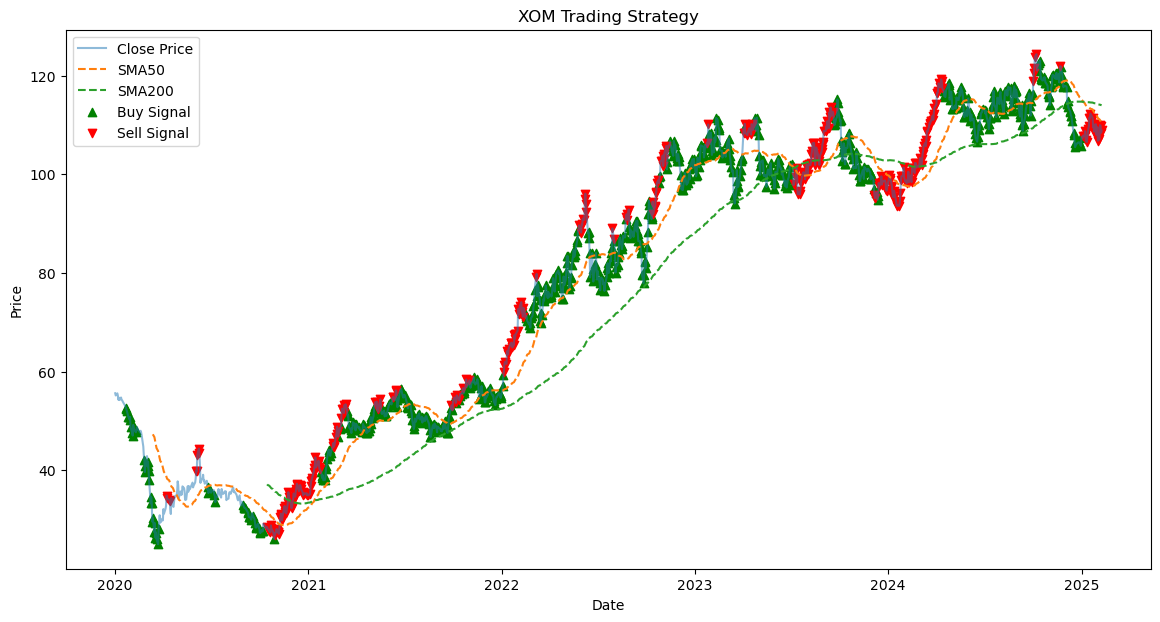

In [17]:
# Test the strategy on AAPL and XOM (less bullish stock)
test_strategy("AAPL")
test_strategy("XOM")